In [1]:
import torch
import torch_geometric
from torch_geometric.datasets import TUDataset, FakeDataset
from torch.utils.data import Subset
from torch_geometric.data import DataLoader
import itertools
from sklearn.model_selection import train_test_split

### Generating example dataset

In [2]:
ds = TUDataset(root = "./data/", name = "MUTAG")
ds = FakeDataset(num_graphs = 100, avg_num_nodes = 10, avg_degree=2)

In [3]:
dl = DataLoader(ds, batch_size = 32, shuffle = True)

C:\Users\ernst\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch_geometric\deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [4]:
for i,b in enumerate(dl):
    break

In [5]:
print(b.is_undirected())

True


### Model generation

#### Pseudo-code

- Graph rewiring

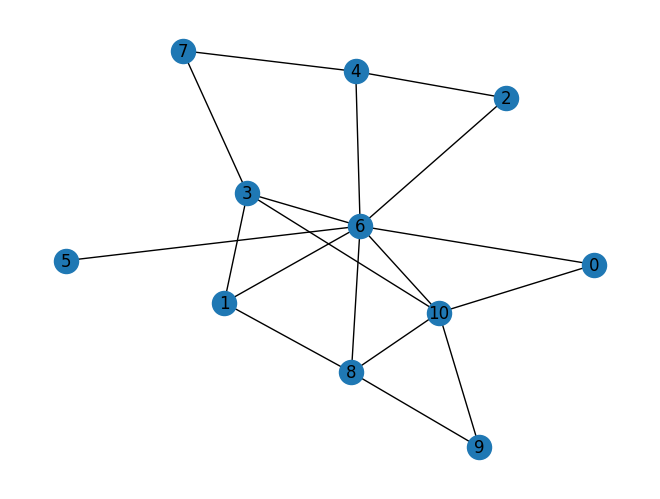

In [6]:
import networkx as nx

g = torch_geometric.utils.to_networkx(b[0], to_undirected=True)
nx.draw(g, with_labels=True)

In [7]:
# Getting all the paths of length k

def get_paths_length_k(A, k):
    """
    Returns the paths of length k in the graph A
    Shape : Num paths x k
    """
    last_A = A.clone()
    k_ = 1
    while k > k_:
        k_ +=1
        if k_ == 2:
            last_A = torch.einsum('ij,jk->ijk', A, A)
        elif k_==3:
            last_A = torch.einsum('ijk,kl->ijkl', last_A, A)
        elif k_ == 4:
            last_A = torch.einsum('ijkl,lm->ijklm', last_A, A)

    #paths = torch.unique(torch.stack(torch.where(last_A!=0),0).T.sort(1)[0],dim=0)
    paths = torch.stack(torch.where(last_A!=0),0).T
    return paths

In [8]:

from torch_geometric.data import DataLoader, Batch, Data
to_undirected = torch_geometric.transforms.ToUndirected()
x = torch.tensor([[-1,0],[1,0],[0,1],[0,-1]])
edge_index = torch.tensor([[0,1],[1,2],[2,3],[0,3]]).T
data = Data(x=x, edge_index=edge_index)
data = to_undirected(data)
batch = Batch.from_data_list([to_undirected(data)])
A = torch_geometric.utils.to_dense_adj(data.edge_index)[0] # Creates adjacency matrix
print(A)
paths = get_paths_length_k(A, 2)
print(paths)
print(len(paths))

tensor([[0., 1., 0., 1.],
        [1., 0., 1., 0.],
        [0., 1., 0., 1.],
        [1., 0., 1., 0.]])
tensor([[0, 1, 0],
        [0, 1, 2],
        [0, 3, 0],
        [0, 3, 2],
        [1, 0, 1],
        [1, 0, 3],
        [1, 2, 1],
        [1, 2, 3],
        [2, 1, 0],
        [2, 1, 2],
        [2, 3, 0],
        [2, 3, 2],
        [3, 0, 1],
        [3, 0, 3],
        [3, 2, 1],
        [3, 2, 3]])
16


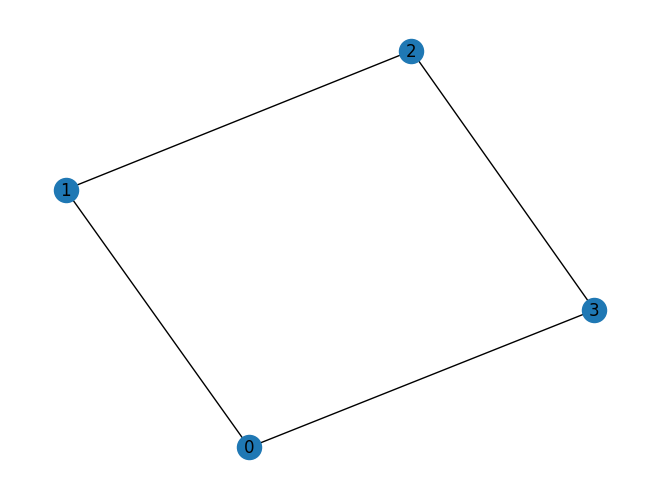

In [11]:
g = torch_geometric.utils.to_networkx(data, to_undirected=True)
nx.draw(g, with_labels=True)

In [32]:
#def get_num_edges(path_length):
#    if path_length==1:
#        return 2
#    elif path_length==2:
#        return 6
#    else:
#        raise NotImplementedError

In [33]:
# Create new node for each different path and link them to the original nodes
def update_graph(paths, nodes_dict, edge_index, path_length = 1):
    num_nodes = len(nodes_dict)
    for path in paths:
        nodes_dict[tuple(path.tolist())] = num_nodes
                
        p_length = path_length
        
        end_nodes_l = []
        while p_length>0:

            for i, j in itertools.combinations(range(len(path) + 1), 2):
                node = tuple(path.tolist()[i:j])
                #print(stuff[i:j])

            #end_nodes_ = itertools.combinations(path.tolist(), p_length)
            #for node in end_nodes_:
                end_nodes_l.append(nodes_dict[node])
            p_length -= 1

        source_nodes = torch.Tensor([num_nodes]).repeat(len(end_nodes_l)).long()
        
        new_edges_0 = torch.stack([source_nodes, torch.Tensor(end_nodes_l).long()],0)
        new_edges_1 = torch.stack([torch.Tensor(end_nodes_l).long(), source_nodes],0)
        new_edges = torch.cat([new_edges_0, new_edges_1],1)
        
        edge_index = torch.cat([edge_index, new_edges],1)
        num_nodes += 1
    return edge_index, nodes_dict

In [46]:
# Example

edge_index = b[0].edge_index # Getting the edge index of the graph

A = torch_geometric.utils.to_dense_adj(b[0].edge_index)[0] # Creates adjacency matrix

nodes_dict = {(i,): i for i in range(A.shape[0])} # Dictionary to keep track of the nodes

paths = get_paths_length_k(A, 1) # Get all the paths of length 2
edge_index_updated, nodes_dict = update_graph(paths, nodes_dict, edge_index, path_length = 1) # Append these paths to the graph

paths = get_paths_length_k(A, 2) # Get all the paths of length 2
edge_index_updated, nodes_dict = update_graph(paths, nodes_dict, edge_index, path_length = 2) # Append these paths to the graph

In [47]:
print(edge_index)
print(A)

tensor([[0, 0, 1, 1, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5, 6, 6],
        [5, 6, 3, 5, 3, 1, 2, 4, 3, 5, 6, 0, 1, 4, 0, 4]])
tensor([[0., 0., 0., 0., 0., 1., 1.],
        [0., 0., 0., 1., 0., 1., 0.],
        [0., 0., 0., 1., 0., 0., 0.],
        [0., 1., 1., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 1., 1.],
        [1., 1., 0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 1., 0., 0.]])


In [48]:
nodes_dict

{(0,): 0,
 (1,): 1,
 (2,): 2,
 (3,): 3,
 (4,): 4,
 (5,): 5,
 (6,): 6,
 (0, 5): 7,
 (0, 6): 8,
 (1, 3): 9,
 (1, 5): 10,
 (2, 3): 11,
 (3, 1): 12,
 (3, 2): 13,
 (3, 4): 14,
 (4, 3): 15,
 (4, 5): 16,
 (4, 6): 17,
 (5, 0): 18,
 (5, 1): 19,
 (5, 4): 20,
 (6, 0): 21,
 (6, 4): 22,
 (0, 5, 0): 23,
 (0, 5, 1): 24,
 (0, 5, 4): 25,
 (0, 6, 0): 26,
 (0, 6, 4): 27,
 (1, 3, 1): 28,
 (1, 3, 2): 29,
 (1, 3, 4): 30,
 (1, 5, 0): 31,
 (1, 5, 1): 32,
 (1, 5, 4): 33,
 (2, 3, 1): 34,
 (2, 3, 2): 35,
 (2, 3, 4): 36,
 (3, 1, 3): 37,
 (3, 1, 5): 38,
 (3, 2, 3): 39,
 (3, 4, 3): 40,
 (3, 4, 5): 41,
 (3, 4, 6): 42,
 (4, 3, 1): 43,
 (4, 3, 2): 44,
 (4, 3, 4): 45,
 (4, 5, 0): 46,
 (4, 5, 1): 47,
 (4, 5, 4): 48,
 (4, 6, 0): 49,
 (4, 6, 4): 50,
 (5, 0, 5): 51,
 (5, 0, 6): 52,
 (5, 1, 3): 53,
 (5, 1, 5): 54,
 (5, 4, 3): 55,
 (5, 4, 5): 56,
 (5, 4, 6): 57,
 (6, 0, 5): 58,
 (6, 0, 6): 59,
 (6, 4, 3): 60,
 (6, 4, 5): 61,
 (6, 4, 6): 62}

In [21]:
# Initialize all nodes with the same color

In [19]:
def path_transform(data):
    edge_index = data.edge_index # Getting the edge index of the graph

    A = torch_geometric.utils.to_dense_adj(data.edge_index)[0] # Creates adjacency matrix

    nodes_dict = {(i,): i for i in range(A.shape[0])} # Dictionary to keep track of the nodes

    paths = get_paths_length_k(A, 1) # Get all the paths of length 2
    edge_index_updated, nodes_dict = update_graph(paths, nodes_dict, edge_index, path_length = 1) # Append these paths to the graph

    paths = get_paths_length_k(A, 2) # Get all the paths of length 2
    edge_index_updated, nodes_dict = update_graph(paths, nodes_dict, edge_index, path_length = 2) # Append these paths to the graph

    data.x = torch.zeros((len(nodes_dict), 4))
    data.edge_index = edge_index_updated
    return data

In [146]:
class GeoDataPL(pl.LightningDataModule):
    def __init__(self, name, batch_size, num_workers = 0):
        super().__init__()
        self.name = name
        self.batch_size = batch_size
        self.num_workers = num_workers
 
    def setup(self, stage = None):

        ds = TUDataset(root = "../data/", name = self.name, pre_transform= path_transform)

        train_idx, test_idx = train_test_split(list(range(len(ds))), test_size = 0.2)
        train_idx, val_idx = train_test_split(list(range(len(ds))), test_size = 0.2) 

        self.train_ds = Subset(ds,train_idx)
        self.val_ds = Subset(ds,val_idx)
        self.test_ds = Subset(ds,test_idx)

        self.num_classes = len(torch.unique(ds._data.y))

    def train_dataloader(self):
        return DataLoader(self.train_ds, batch_size = self.batch_size, num_workers = self.num_workers, shuffle = True)
    
    def val_dataloader(self):
        return DataLoader(self.val_ds, batch_size = self.batch_size, num_workers = self.num_workers)
    
    def test_dataloader(self):
        return DataLoader(self.test_ds, batch_size = self.batch_size, num_workers = self.num_workers)



In [148]:
# PL MOdel

class GNNModel(pl.LightningModule):
    def __init__(self, num_classes, lr):
        super().__init__()
        self.num_classes = num_classes
        self.lr = lr
        self.model = torch_geometric.nn.GCNConv(4, num_classes)
        self.loss = torch.nn.CrossEntropyLoss()

    def forward(self, x, edge_index):
        return self.model(x, edge_index)
    
    def training_step(self, batch, batch_idx):
        x, edge_index, y = batch.x, batch.edge_index, batch.y
        y_hat = self(x, edge_index)
        loss = self.loss(y_hat, y)
        self.log("train_loss", loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, edge_index, y = batch.x, batch.edge_index, batch.y
        y_hat = self(x, edge_index)
        loss = self.loss(y_hat, y)
        self.log("val_loss", loss)
        return loss
    
    def test_step(self, batch, batch_idx):
        x, edge_index, y = batch.x, batch.edge_index, batch.y
        y_hat = self(x, edge_index)
        loss = self.loss(y_hat, y)
        self.log("test_loss", loss)
        return loss
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr = self.lr)
    
    def predict(self, x, edge_index):
        return self(x, edge_index)
    


In [150]:
dl = GeoDataPL("MUTAG", 32, 0)
dl.setup()
num_classes = dl.num_classes

mod = GNNModel(num_classes= num_classes, lr = 0.001 )

In [152]:
trainer = pl.Trainer(max_epochs = 10)
trainer.fit(mod, dl)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/edebrouwer/miniconda3/envs/sheaf/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(

  | Name  | Type             | Params
-------------------------------------------
0 | model | GCNConv          | 10    
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
10        Trainable params
0         Non-trainable params
1

Sanity Checking: 0it [00:00, ?it/s]

/Users/edebrouwer/miniconda3/envs/sheaf/lib/python3.9/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/Users/edebrouwer/miniconda3/envs/sheaf/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


ValueError: Expected input batch_size (4986) to match target batch_size (32).

# WIP

In [73]:
A2 = torch.einsum('ij,jk->ijk', A, A)
A3 = torch.einsum('ijk,kl->ijkl', A2, A)
A4 = torch.einsum('ijkl,lm->ijklm', A3, A)
A5 = torch.einsum('ijklm,mn->ijklmn', A4, A)

In [88]:
.shape

torch.Size([65, 3])

In [77]:
A.sum()

tensor(22.)

tensor(0.)

In [19]:
from torch_geometric.nn import MessagePassing

In [ ]:
class AggGraphClass(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super().__init__(aggr='add')  # "Add" aggregation (Step 5).
        self.lin = nn.Linear(in_channels, out_channels, bias=False)
        self.bias = nn.Parameter(torch.empty(out_channels))

        self.node_emb = nn.Sequential(nn.Linear(out_channels,out_channels),nn.ReLU())

        self.reset_parameters()

    def reset_parameters(self):
        self.lin.reset_parameters()
        self.bias.data.zero_()

    def forward(self, x, edge_index):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]

        ## Step 1: Add self-loops to the adjacency matrix.
        #edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        # Step 2: Linearly transform node feature matrix.
        x = self.lin(x)

        # Step 3: Compute normalization.
        row, col = edge_index
        deg = degree(col, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        # Step 4-5: Start propagating messages.
        out = self.propagate(edge_index, x=x)

        # Step 6: Apply a final bias vector.
        out += self.bias

        return out

    def message(self, x_j):
        # x_j has shape [E, out_channels]

        # Step 4: Normalize node features.
        return self.node_emb(x_j)
    
    def update(self, aggr_out):
        # aggr_out has shape [N, out_channels]

        # Step 5: Return new node embeddings.
        return aggr_out